# Описание проекта

Дан датасет online_shoppers_intention.csv, который содержит информацию о посетителях интернет-магазина и их поведении на сайте. Необходимо проанализировать данный датасет, построить модель машинного обучения, которая сможет предсказывать, приносят ли действия пользователя Revenue или нет.

## 1 Открытие файла и предобработка данных

In [1]:
!pip install lightgbm

In [2]:
!pip install hyperopt

Импортируем нужные нам библиотеки

In [3]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

from random import randint
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder

Откроем файл и посмотрим на данные

In [4]:
df = pd.read_csv("C:/Users/n07no/OneDrive/Документы/online_shoppers_intention.csv")

In [5]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

С первого взгдяда не обнаружилось пропущенных значений. Однако в глаза бросается написание столбцов, приведем их к нужному виду, посмотрим есть ли пропущенные значения в датасете и приведем колонки weekend и revenue к числововму типу данных

In [8]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [9]:
df.columns = map(str.lower, df.columns)

In [10]:
df.rename(columns = {'operatingsystems':'operating_systems', 'traffictype':'traffic_type ', 
                     'productrelated':'product_related', 'bouncerates':'bounce_rates', 'exitrates':'exit_rates',
                     'pagevalues':'page_values', 'specialday':'special_day', 'visitortype':'visitor_type',
                     'productrelated_duration':'product_related_duration '}, inplace = True )

In [11]:
df['revenue'] = df['revenue'].astype(int)

In [12]:
df['weekend'] = df['weekend'].astype(int)

Посмотрим на дубликаты в данных

In [13]:
df.duplicated() 

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Length: 12330, dtype: bool

In [14]:
df['month'].duplicated()

0        False
1         True
2         True
3         True
4         True
         ...  
12325     True
12326     True
12327     True
12328     True
12329     True
Name: month, Length: 12330, dtype: bool

Дубликаты в данных удалять нельзя, поскольку это может сильно исказить результаты анализа

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   administrative             12330 non-null  int64  
 1   administrative_duration    12330 non-null  float64
 2   informational              12330 non-null  int64  
 3   informational_duration     12330 non-null  float64
 4   product_related            12330 non-null  int64  
 5   product_related_duration   12330 non-null  float64
 6   bounce_rates               12330 non-null  float64
 7   exit_rates                 12330 non-null  float64
 8   page_values                12330 non-null  float64
 9   special_day                12330 non-null  float64
 10  month                      12330 non-null  object 
 11  operating_systems          12330 non-null  int64  
 12  browser                    12330 non-null  int64  
 13  region                     12330 non-null  int

Посмотрим какие значения есть в столбцах visitor_type и month

In [16]:
df['visitor_type'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: visitor_type, dtype: int64

In [17]:
df['month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: month, dtype: int64

In [18]:
df.head(15)

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,0,0
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,0,0
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,1,0
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,0,0
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,0,0


### Вывод

Данные в хорошем состоянии, не особо нуждаются в предобработке (отсутсвуют пропущенные значения). Нулевые значения во всех столбцах удалять не нужно, т.к. они могут повлиять на итоговый результат исследования в негативном ключе. На этом этапе были изменены типы данных в столбцах "revenue" и "weekend" и названия столбцов для более удобной работы с ними.

## 2 Анализ данных

Переходим к анализу. Здесь посмотрим от чего больше всего зависит прибыль

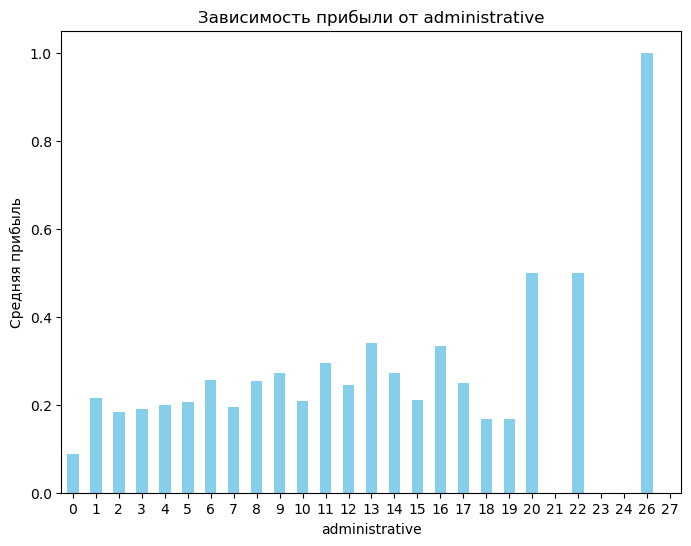

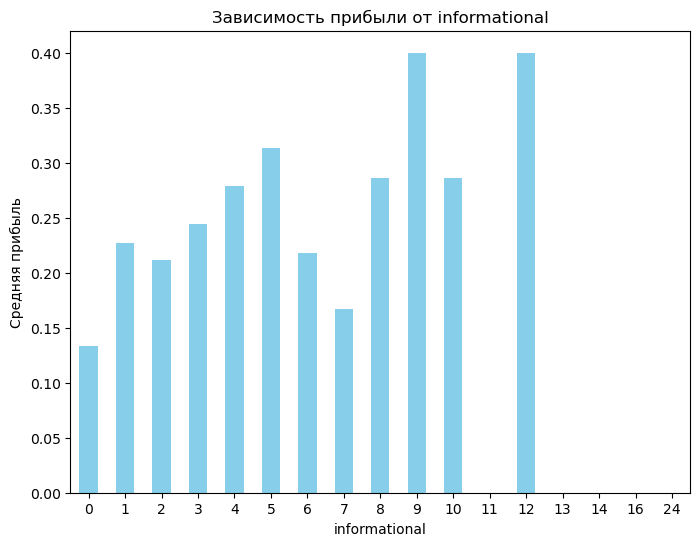

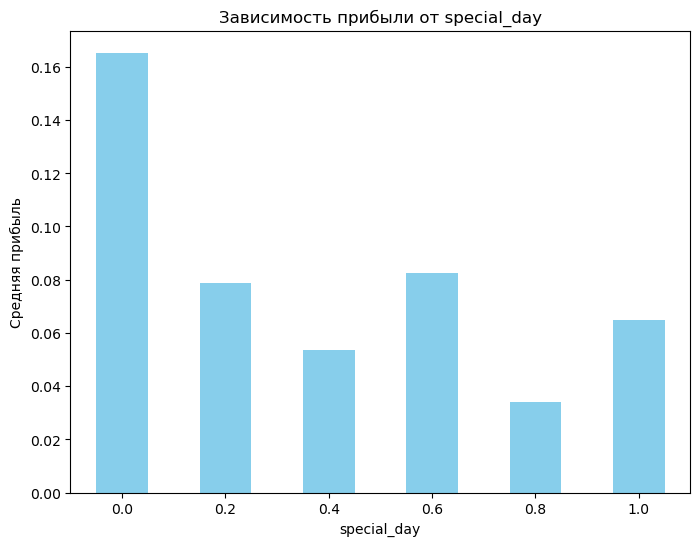

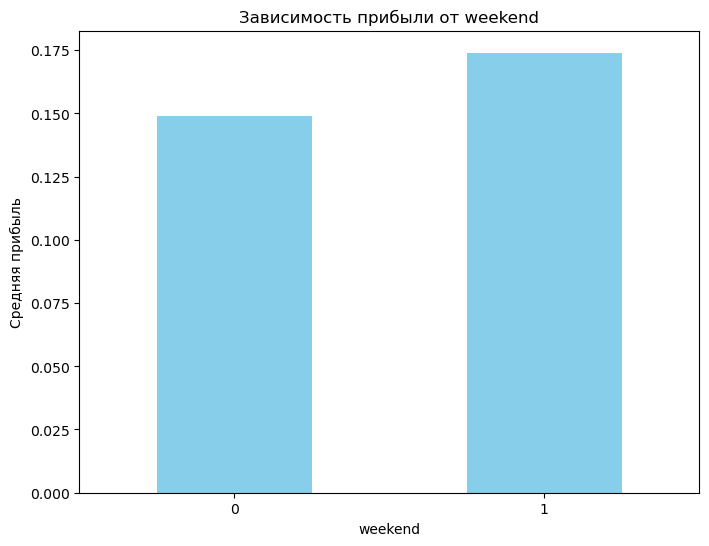

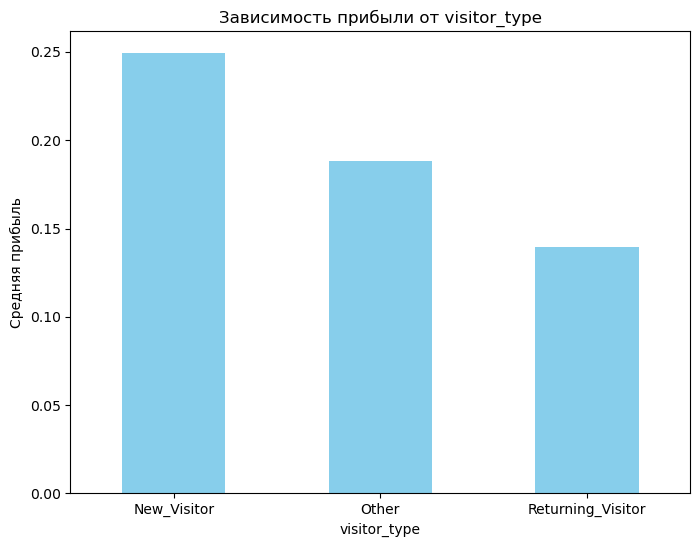

In [19]:
# Список столбцов, для которых бужут строится график
columns_to_plot = ['administrative', 'informational', 'special_day', 'weekend', 'visitor_type']

# Итерация по выбранным столбцам и построение графиков
for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    # Замените 'column1' на текущее значение столбца в цикле
    df.groupby(column)['revenue'].mean().plot(kind='bar', color='skyblue')
    plt.title(f'Зависимость прибыли от {column}')
    plt.xlabel(column)
    plt.ylabel('Средняя прибыль')
    plt.xticks(rotation=0)
    plt.show()

In [20]:
data_for_correlation = df[['administrative', 'administrative_duration', 'product_related', 'bounce_rates', 'exit_rates', 'page_values', 'weekend', 'revenue']]

# Вычислим корреляцию методом корреляции Пирсона
correlation_matrix = data_for_correlation.corr()

# Выведем матрицу корреляции
print(correlation_matrix)

                         administrative  administrative_duration  \
administrative                 1.000000                 0.601583   
administrative_duration        0.601583                 1.000000   
product_related                0.431119                 0.289087   
bounce_rates                  -0.223563                -0.144170   
exit_rates                    -0.316483                -0.205798   
page_values                    0.098990                 0.067608   
weekend                        0.026417                 0.014990   
revenue                        0.138917                 0.093587   

                         product_related  bounce_rates  exit_rates  \
administrative                  0.431119     -0.223563   -0.316483   
administrative_duration         0.289087     -0.144170   -0.205798   
product_related                 1.000000     -0.204578   -0.292526   
bounce_rates                   -0.204578      1.000000    0.913004   
exit_rates                     -0.292

### Вывод

В основном прибыль зависит от

-количества посещений страниц с административной информацией на веб-сайте

-количества информационных страниц на веб-сайте

-"специального дня"

-посещения сайта по выходным дням (наибольшая прибыль именно с посещений в выходные дни, возможно это связано с наличием свободного времени у пользователей)

-типа посетителя (в основном зависит от новых пользователей).

## 4 Обучение моделей

Построим модели для предсказаний, оценим accuracy каждой модели и выберем наилучшую из них.

Для начала приведет категориальные признаки в количественные

In [21]:
df = pd.get_dummies(df, columns=['month', 'visitor_type'], drop_first=True)

In [22]:
cat_features = ['month', 'visitor_type']

Разделяем признаки и целевую переменную

In [23]:
X = df.drop('revenue', axis=1)
y = df['revenue']

Разделение данных на тренировочный и тестовый наборы

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабируем данные

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Линейная регрессия

In [26]:
# Инициализация и обучение модели линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Получите предсказания модели для тестового набора данных
y_pred = linear_model.predict(X_test)

# Определите пороговое значение для классификации прибыльных и неприбыльных действий
threshold = .5

# Классифицируйте действия пользователя на прибыльные и неприбыльные
predicted_labels = (y_pred > threshold).astype(int)

# Оцените качество классификации
accuracy = accuracy_score(y_test, predicted_labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8625304136253041


### Случайный лес

In [27]:
# Определение функции для оптимизации гиперпараметров
def objective(params):
    # Параметры для оптимизации
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])

    # Создание модели случайного леса с заданными параметрами
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=12345,
    )

    # Вычисление средней точности на кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return -score.mean()  # Минимизируем отрицательную точность

# Определение пространства поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
}

# Создание объекта Trials для отслеживания итераций оптимизации
trials = Trials()

# Запуск оптимизации
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Вывод наилучших гиперпараметров
print("Best Hyperparameters:")
print(best)

# Создание модели с наилучшими гиперпараметрами и обучение ее
best_rf_classifier = RandomForestClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    random_state=12345,
)

best_rf_classifier.fit(X_train, y_train)

y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

auc_roc = roc_auc_score(y_test, y_pred_proba)


print("AUC-ROC on Test Data:", auc_roc)

100%|██████████| 50/50 [18:41<00:00, 22.42s/trial, best loss: -0.9071368649177691]
Best Hyperparameters:
{'max_depth': 30.0, 'min_samples_leaf': 2.0, 'min_samples_split': 5.0, 'n_estimators': 498.0}
AUC-ROC on Test Data: 0.9275205569467383


### Логистическая регрессия

In [28]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

auc_roc = roc_auc_score(y_test, y_pred_proba)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8900480106085094


### Вывод

Лучший результат показала модель Случайного Леса. Эта модель делает более точные предсказания

## Общий вывод

В ходе работы была проведена предобработка данных, а именно

-изменены названия колонок,

-типы данных в столбцах revenue и weekend.

Были обучены модели линейной регрессии и случайного леса и посчитана AUC_ROC. Как выяснилось, более точные прогнозы делает модель случайного леса